In [25]:
import numpy as np
from itertools import combinations
from scipy.stats import binom
import scipy.special
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from decimal import *

In [5]:
def get_index_lists_I_and_J(E,n,N,d):
    I_n = list(range(d))
    J_n = list(range(d))
    n_ = n+1
    for m in reversed(range(d)):
        if E[m,n_-1] in E[J_n,n_]:
            del I_n[m]
            t_J_n = [i for i in J_n if E[i,n_] == E[m,n_-1] ]
            m_max = max(t_J_n)
            del J_n[m_max]
    return I_n,J_n

In [6]:
def diff_of_lists(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [7]:
def get_permutation_I(I_n,d):
    permutation = [0]*d
    r_n = np.shape(I_n)[0]
    complementary_I_n = diff_of_lists(list(range(d)),I_n)
    c_r_n = d-r_n
    for i in range(r_n):
        permutation[I_n[i]] = i
    for i in range(c_r_n):
        permutation[complementary_I_n[i]] = i + r_n
    return permutation

In [8]:
def get_v_n_w_n(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n = np.zeros((r_n))
    w_n = np.zeros((r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        v_n_index = permutation_I_n[m]
        nom_v_n = E[m,n]*np.ones((r_n,1)) - E[list(J_n),n+1]
        I_n_without_m = diff_of_lists(I_n,[m])
        cardinal_I_n_without_m = np.shape(I_n_without_m)[0]
        denom_v_n = E[m,n]*np.ones((cardinal_I_n_without_m,1)) - E[list(I_n_without_m),n]
        v_n[v_n_index] = np.sqrt(-np.prod(nom_v_n)/np.prod(denom_v_n))
    for m in J_n:
        w_n_index = permutation_J_n[m]
        nom_w_n = E[m,n+1]*np.ones((r_n,1)) - E[list(I_n),n]
        J_n_without_m = diff_of_lists(J_n,[m])
        cardinal_J_n_without_m = np.shape(J_n_without_m)[0]
        denom_w_n = E[m,n+1]*np.ones((cardinal_J_n_without_m,1)) - E[list(J_n_without_m),n+1]
        w_n[w_n_index] = np.sqrt(np.prod(nom_w_n)/np.prod(denom_w_n))
        
    return v_n,w_n

In [9]:
def get_permutation_matrix(permutation,d):
    permutation_matrix = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            if i == permutation[j]:
                permutation_matrix[i,j] = 1
    return permutation_matrix

In [10]:
def get_W_n_matrix(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n)
    W_n_matrix = np.zeros((r_n,r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        for m_ in J_n:
            v_n_index = permutation_I_n[m]
            w_n_index = permutation_J_n[m_]
            W_n_matrix[v_n_index,w_n_index] = 1/(E[m_,n+1]-E[m,n])*v_n[v_n_index]*w_n[w_n_index]
    return W_n_matrix

In [11]:
def get_padded_vector(v,d):
    r_n = np.shape(v)[0]
    v_padded = np.zeros((d,))
    v_padded[0:r_n] = v
    return v_padded

In [12]:
def get_extended_matrix_W(W_n_matrix,d):
    r_n = np.shape(W_n_matrix)[0]
    W_extended = np.eye(d)
    W_extended[0:r_n,0:r_n] = W_n_matrix
    return W_extended

In [13]:
def get_F(d,N,E,mu_vector):
    F_test = np.zeros((d,N))
    U_n_1 = np.eye(d)
    for n in range(N):
        #print(n)
        if n ==0:
            M = np.eye(d)
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,M)
        else:
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,U_n_1)
    return F_test

In [14]:
def generate_random_diagonal_unimodular_matrix(d):
    vector = np.ones((1,d)) - 2*np.random.binomial(1, 0.5, d)
    return np.diag(vector[0])
    #return np.eye(d)

In [15]:
def get_F_n_U_n(n,d,N,E,mu_vector,U_n_1):
    #print(n)
    if n==1:
        M = np.eye(d)
        v = np.sqrt(mu_vector[0])*M[:,0]
        return v,np.eye(d)
    I_n,J_n = get_index_lists_I_and_J(E,n-1,N,d)
    r_n = np.shape(I_n)[0]
    permutation_matrix_I_n = get_permutation_matrix(get_permutation_I(I_n,d),d)
    permutation_matrix_J_n = get_permutation_matrix(get_permutation_I(J_n,d),d)
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n-1)
    W_extended = get_extended_matrix_W(get_W_n_matrix(E,I_n,J_n,d,n-1),d)
    v_padded = get_padded_vector(v_n,d)
    V_n = generate_random_diagonal_unimodular_matrix(d)
    U_n = np.dot(np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),W_extended),permutation_matrix_J_n)
    f_n = np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),v_padded)
    return f_n,U_n

## Create an eigensteps

In [165]:
def get_eigensteps_random(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        print("n")
        print(n)
        for k in range(n-1, -1, -1):
            print("k")
            print(k)
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n,n])
            B_n_1_k = min(E[k,n+1],min(B_array))
            #print("argmin")
            #print(np.argmin(B_array))
            u = np.random.uniform(0,1)
            theta = 0.8
            delta_n_1_k = B_n_1_k - A_n_1_k
            #print("k")
            #print(k)
            #print(B_n_1_k)
            #print(A_n_1_k)
            #print(delta_n_1_k)
            #print(u)
            E[k,n] = A_n_1_k + u*delta_n_1_k
            #E[k,n] = A_n_1_k
    return E

In [115]:
def get_eigensteps_mean(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        #print(n)
        for k in range(n, -1, -1):
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n,n])
            B_n_1_k = min(E[k,n+1],min(B_array))
            u = np.random.uniform(0,1)
            E[k,n] = B_n_1_k
    return E

In [116]:
N= 50
d = 2
E = np.zeros((N,N)) #(d,N)
mu_vector = d/N*np.ones((N,1))
lambda_vector = np.zeros((N))
lambda_vector[0:d] = np.ones((d))

In [117]:
mu_vector = np.linspace(1, 0.1, num=N)
sum_mu_vector = np.sum(mu_vector)
mu_vector = d/sum_mu_vector*mu_vector

mu_vector = d/N*np.ones((N,1))

In [166]:

E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
E_ = np.zeros((d,N+1))
for i in range(d):
    E_[i,1:N+1] = E_test[i,:] 
F_test = get_F(d,N,np.asmatrix(E_),mu_vector)


n
48
k
47
k
46
k
45
k
44
k
43
k
42
k
41
k
40
k
39
k
38
k
37
k
36
k
35
k
34
k
33
k
32
k
31
k
30
k
29
k
28
k
27
k
26
k
25
k
24
k
23
k
22
k
21
k
20
k
19
k
18
k
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
47
k
46
k
45
k
44
k
43
k
42
k
41
k
40
k
39
k
38
k
37
k
36
k
35
k
34
k
33
k
32
k
31
k
30
k
29
k
28
k
27
k
26
k
25
k
24
k
23
k
22
k
21
k
20
k
19
k
18
k
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
46
k
45
k
44
k
43
k
42
k
41
k
40
k
39
k
38
k
37
k
36
k
35
k
34
k
33
k
32
k
31
k
30
k
29
k
28
k
27
k
26
k
25
k
24
k
23
k
22
k
21
k
20
k
19
k
18
k
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
45
k
44
k
43
k
42
k
41
k
40
k
39
k
38
k
37
k
36
k
35
k
34
k
33
k
32
k
31
k
30
k
29
k
28
k
27
k
26
k
25
k
24
k
23
k
22
k
21
k
20
k
19
k
18
k
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
44
k
43
k
42
k
41
k
40
k
39
k
38
k
37
k
36
k
35
k
34
k
33
k
32
k
31
k
30
k
29
k
28
k
27


In [158]:
def generate_leverage_scores_vector_with_dirichlet(d,k,nn_cardinal):
    getcontext().prec = 3
    mu_vector = np.float16(np.zeros((d,)))
    mu_vector_2 = np.float16(np.zeros((d,)))
    not_bounded = 1
    while(not_bounded == 1):
        mu_vector[0:nn_cardinal] = (k*np.random.dirichlet([1]*nn_cardinal, 1))[0]
        mu_vector = np.flip(np.sort(mu_vector),axis = 0)
        if max(mu_vector)<=1:
            not_bounded = 0
    for i in range(nn_cardinal):
        mu_vector_2[i] = round(mu_vector[i],4)
    mu_vector_2 = k*mu_vector_2/np.sum(mu_vector_2)
    return list(mu_vector_2)

In [159]:
def generate_orthonormal_matrix_with_leverage_scores_ES(N,d,lv_scores_vector,versions_number,nn_cardinal_list):

    lambda_vector = np.zeros((N))
    lambda_vector[0:d] = np.ones((d))

    #mu_vector = np.linspace(1, 0.1, num=N)
    #sum_mu_vector = np.sum(mu_vector)
    #mu_vector = d/sum_mu_vector*mu_vector
    Q = np.zeros((N,d))
    previous_Q = np.zeros((versions_number+1,N,d))
    #mu_vector = d/N*np.ones((N,1))
    E = np.zeros((N,N)) #(d,N)
    counter = 0
    for j in nn_cardinal_list:
        #print("counter")
        #print(counter)
        mu_vector = generate_leverage_scores_vector_with_dirichlet(N,d,j)
        #print(np.sum(mu_vector))
        print(mu_vector)
        E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
        E_ = np.zeros((d,N+1))
        for i in range(d):
            E_[i,1:N+1] = E_test[i,:] 
        #print(E_test)
        F_test = get_F(d,N,np.asmatrix(E_),mu_vector)
        previous_Q[counter,:,:] = np.transpose(F_test)
        Q = np.transpose(F_test)
        counter = counter +1
    return Q,previous_Q

In [160]:
E_column_sum = np.zeros((N,1))
for n in range(N):
    E_column_sum[n] = np.sum(E_test[:,n])


In [167]:
Q,previous_Q = generate_orthonormal_matrix_with_leverage_scores_ES(20,2,[],1,[20])

[0.62646, 0.1853, 0.14941, 0.13892, 0.095825, 0.088989, 0.088806, 0.083618, 0.079773, 0.077393, 0.074829, 0.069214, 0.06781, 0.052612, 0.049408, 0.030197, 0.017593, 0.017502, 0.0040016, 0.0027008]
n
18
k
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
17
k
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
16
k
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
15
k
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
14
k
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
13
k
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
12
k
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
11
k
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
10
k
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
9
k
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
8
k
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
7
k
6
k
5
k
4
k
3
k
2
k
1
k
0
n
6
k
5
k
4
k
3
k
2
k
1
k
0
n
5
k
4
k
3
k
2
k
1
k
0
n
4
k
3
k
2
k
1
k
0
n
3
k
2
k
1
k
0
n
2
k
1
k
0
n
1
k
0
n


/Users/abelhadj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Users/abelhadj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


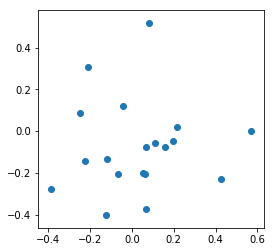

In [121]:
plt.scatter(previous_Q[0,0:N,0], previous_Q[0,0:N,1])
plt.gca().set_aspect('equal')
plt.show()

In [32]:
print(np.shape(previous_Q))

(4, 20, 2)


In [393]:
np.dot(F_test[:,0:N],F_test[:,0:N].T)

array([[  1.00000000e+00,  -7.89299182e-17],
       [ -7.89299182e-17,   1.00000000e+00]])

In [394]:
np.diag(np.dot(F_test[:,0:N].T,F_test[:,0:N]))

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [384]:
mu_vector

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [161]:
x = ortho_group.rvs(3)

In [164]:
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [idx for idx,item in enumerate(seq) if item in seen or seen_add(item)]

print(list_duplicates([1, 2, 3, 2, 1, 5, 6, 5, 5, 5]))
# [3, 4, 7, 8, 9]

[3, 4, 7, 8, 9]
